In [3]:
# Settings
#filename    = '/home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5'
#filename     = '/home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2016_02_05/Kr83m_gasTPC_160205_medianBL.hdf5'
#filename    = '/home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2015_10_02/Kr_Measurement_1000TH_1_151002.hdf5'
#filename    = '/media/axel/cf2b7088-fe0f-419a-a101-07493d88971c/kabelchange.hdf5.hdf5'
filename = "/home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2016_02_12/Cs137_Thr3000ADC_160211_000.hdf5"
file_format = 'hdf5'
fig_save_path = filename[:-5] + "_plots/"
#loglevel    = 'DEBUG'

In [4]:
save_plots = True
plot_format = ".png"
if save_plots:
    import os
    os.makedirs(fig_save_path, exist_ok=True)
    def plot_save(plot_name, fig):
        fig.savefig(fig_save_path + plot_name + plot_format)

In [5]:
import logging
log = logging.getLogger('Gaseous basic statistics')
log.setLevel('DEBUG')

import numpy as np
import pandas as pd
import matplotlib   # Needed for font size spec, color map transformation function bla bla
%matplotlib inline
matplotlib.rc('font', size=16)
import matplotlib.pyplot as plt

import matplotlib.dates as md
import datetime as dt
import time
from matplotlib.colors import LogNorm, LinearSegmentedColormap
# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    log.debug("You don't have tqdm, I can't give you a nice progress bar...")
    def dummy(*args,**kwargs):
        return args[0]
    tqdm = dummy

from recarray_tools import append_fields, fields_view, group_by, filter_on_fields, fields_data

peak_types = [b's1', b's2', b'unknown', b'noise', b'lone_hit']

In [6]:
##
# Load the data
##
try:
    events = None
    hits = None
    peaks = None
except Exception:
    pass

log.debug("Now loading %s (file format=%s)..." % (filename, file_format))

# Slurp peaks and events into memory
# WARNING: For a large dataset, use pax to remove big low-level fields first
# (area_per_channel, does_channel_contribute, does_channel_have_noise)
try:
    # Load the file using pax 3's IO code
    from pax.formats import flat_data_formats
    ioformat = flat_data_formats[file_format]()
    ioformat.open(filename, 'r')
    events = ioformat.read_data('Event')
    try:
        peaks = ioformat.read_data('Peak')
    except KeyError:
        peaks = None
        log.info("There is no peak table")
    hits = ioformat.read_data('all_hits')
    ioformat.close()
except ImportError:
    log.debug("You don't have pax 3 installed, falling back to HDF5-specific code...")
    import h5py
    f = h5py.File(filename)
    events = f.get('Event')[:]
    peaks = f.get('Peak')[:]
    hits = f.get('all_hits')[:]
    f.close()
#if peaks != None:
    log.info("Loaded %s, found %d hits (%0.2f MB RAM), clustered into %d peaks (%0.2f MB RAM) in %d events (%0.2f MB RAM)" % (
    filename, len(hits), hits.nbytes/10**6, len(peaks), peaks.nbytes/10**6, len(events), events.nbytes/10**6))
#if len(events) == 0:
#    raise ValueError("You don't have any events in this dataset!")

DEBUG:Gaseous basic statistics:Now loading /home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2016_02_12/Cs137_Thr3000ADC_160211_000.hdf5 (file format=hdf5)...


In [7]:
log.info("Loaded %s, found %d hits (%0.2f MB RAM), clustered into %d peaks (%0.2f MB RAM) in %d events (%0.2f MB RAM)" % (
    filename, len(hits), hits.nbytes/10**6, len(peaks), peaks.nbytes/10**6, len(events), events.nbytes/10**6))

INFO:Gaseous basic statistics:Loaded /home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2016_02_12/Cs137_Thr3000ADC_160211_000.hdf5, found 12874450 hits (1248.82 MB RAM), clustered into 1341750 peaks (182.48 MB RAM) in 99876 events (23.77 MB RAM)


INFO:Gaseous basic statistics:Loaded 99876 events (23.77 MB RAM)


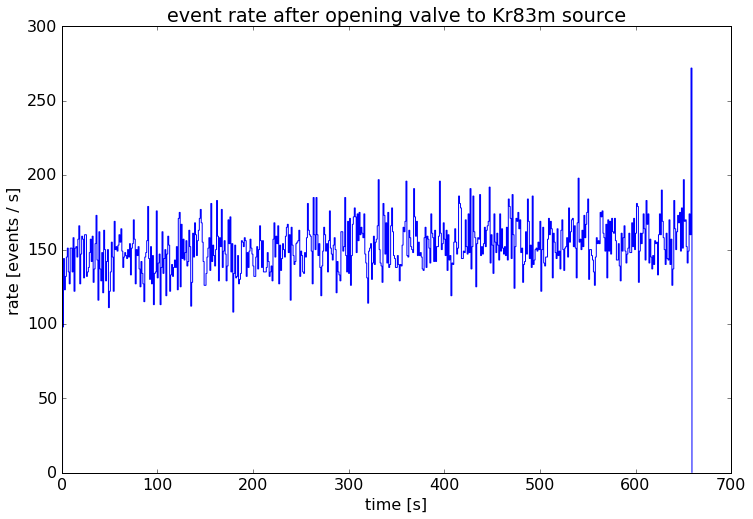

In [8]:
# Adding extra fields
log.info("Loaded %d events (%0.2f MB RAM)" %(len(events), events.nbytes/1e6))
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_ylabel("rate [events / s]")
ax.set_xlabel("time [s]")
ax.set_title("event rate after opening valve to Kr83m source")
a = ax.hist((events["start_time"]-events["start_time"][0])//1e9, bins=(events["start_time"][-1]-events["start_time"][0])//1e9 , histtype="step")
if save_plots:
    plot_save("rate_vs_time",fig)

In [9]:
log.info("Found %d hits (%s MB RAM)"% (len(hits),hits.nbytes//1e6))

INFO:Gaseous basic statistics:Found 12874450 hits (1248.0 MB RAM)


(array([ 939385, 1083956, 1294364, 1139788,  958837,  322487,  929419,
        823125,  831173, 1458883,  689508,  749846,  800405,  853274]), array([  0.        ,   0.99285714,   1.98571429,   2.97857143,
         3.97142857,   4.96428571,   5.95714286,   6.95      ,
         7.94285714,   8.93571429,   9.92857143,  10.92142857,
        11.91428571,  12.90714286,  13.9       ]))


/home/axel/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


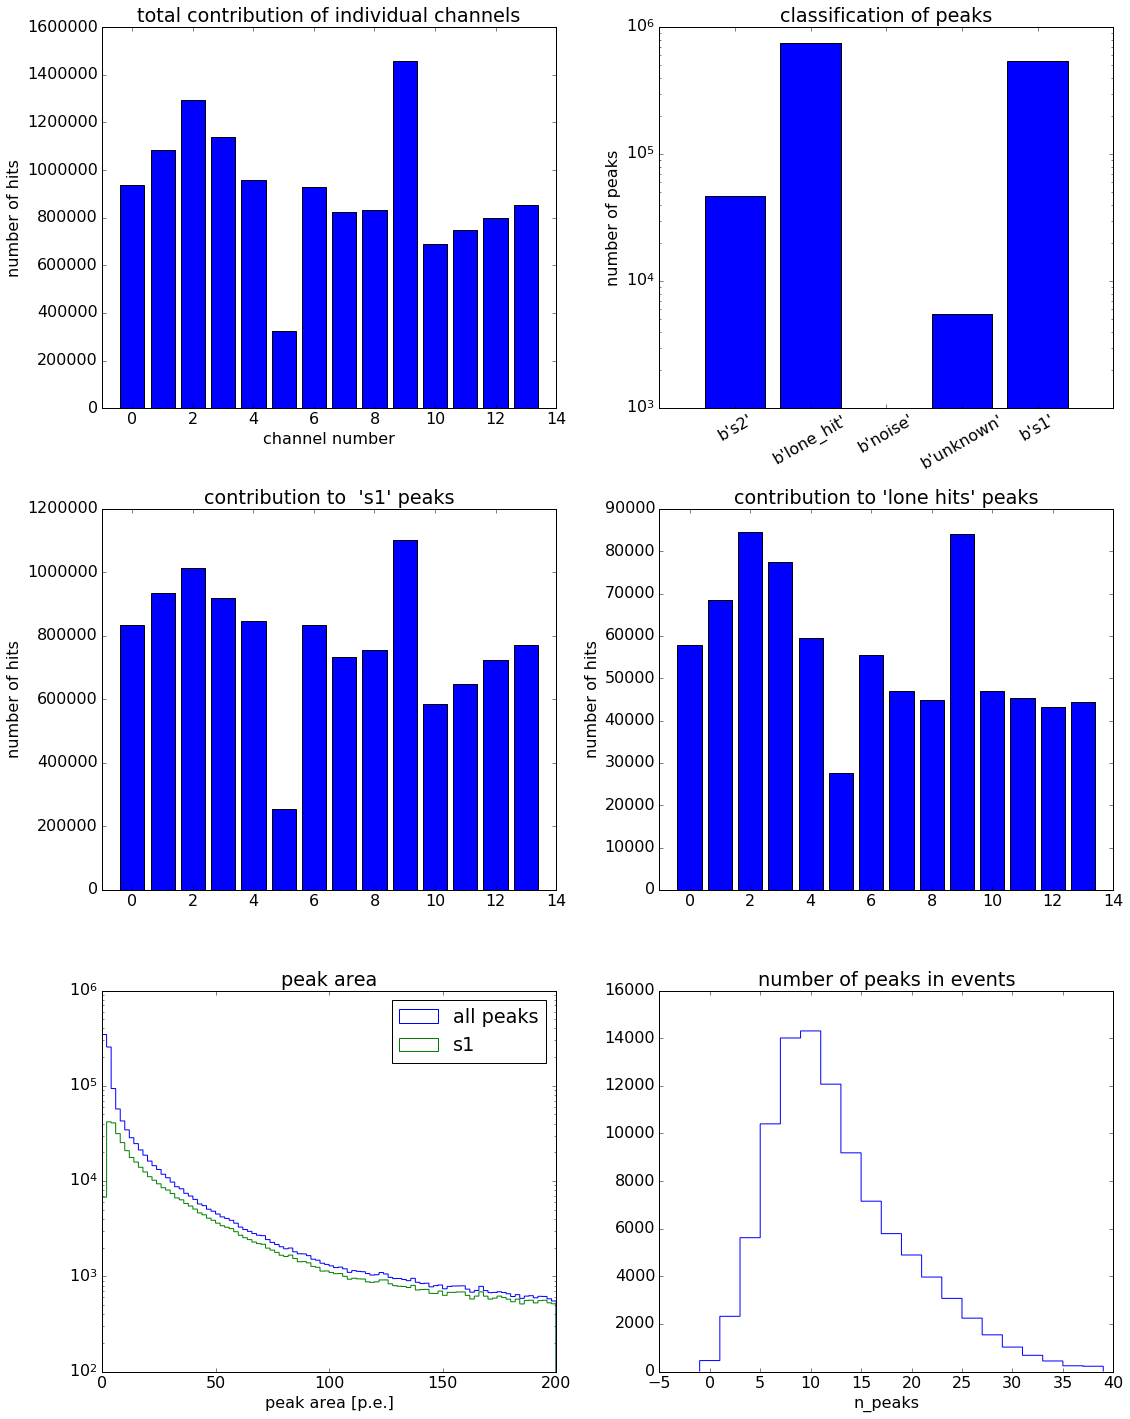

In [58]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,20), squeeze=False)
area_right_boundary = 200
area_bins = 100

if True:
    
    ### making histogram of hits
    z = np.histogram(hits["channel"], bins=14, range=(0,13.9))
    print(z)
    plt.cla()
    ax1.bar(range(14),z[0], align="center")
    ax1.set_xlabel("channel number")
    ax1.set_ylabel("number of hits")
    ax1.set_title("total contribution of individual channels")
    ax1.set_xlim((-1,14))
    
    ### now checking how peaks were identified
    peak_type_sums = dict()
    for peaktype in peak_types:
        z = (peaks["type"] == peaktype)
        peak_type_sums[peaktype] = sum(z)
    ax2.bar(range(len(peak_types)), peak_type_sums.values(),align="center")
    ax2.set_ylabel("number of peaks")
    xlabels = [""]
    xlabels.extend(list(peak_type_sums.keys()))
    ax2.set_xticklabels(labels= xlabels, rotation = 30)
    ax2.set_title("classification of peaks")
    ax2.set_yscale("log")
    #ax2.set_xlim((-1,14))
    
    ### 

    # making a histogram of contributing channels towards peaks
    # looking at coincidential peaks (type != lone_hit) 
    s1_peaks = peaks["n_contributing_channels"] >= 2
    lone_hits = peaks["type"] == b"lone_hit"

    a = pd.DataFrame(peaks[s1_peaks]["hits_per_channel"])
    b = pd.DataFrame(peaks[lone_hits]["hits_per_channel"])
    ax3.bar(list(a), list(a.sum()),align="center")
    ax3.set_title("contribution to  's1' peaks")
    
    ax4.set_title("contribution to 'lone hits' peaks")
    ax4.bar(list(b), list(b.sum()),align="center")
    
    ax3.set_xlim((-1,14))
    ax3.set_ylabel("number of hits")
    ax4.set_xlim((-1,14))
    ax4.set_ylabel("number of hits")
    
    ax5.set_title("peak area")
    ax5.hist(peaks["area"], bins=area_bins, histtype="step", range=(0,area_right_boundary), label="all peaks")
    ax5.hist(peaks[s1_peaks]["area"], bins=area_bins, histtype="step", range=(0,area_right_boundary), label = "s1")
    ax5.set_xlabel("peak area [p.e.]")
    #ax5.set_ylabel("#")
    ax5.set_xlim((0,area_right_boundary))
    ax5.legend(loc="best")
    ax5.set_yscale("log")
    
    ax6.set_title("number of peaks in events")
    ax6.hist(events["n_peaks"], bins=20, histtype="step", range=(0,40), align="left")
    ax6.set_xlabel("n_peaks")
    
    fig.tight_layout()
    fig.show()
    if save_plots:
        plot_save("overview",fig)

In [11]:
### Now finding events that contain >=2 peaks
### Then plotting energy of first peak (ordered by area) vs the second peak

multi_peak_events = events[events["n_peaks"]>= 2]

peak_by_event = group_by(peaks, "Event")

main_peaks = []
secondary_peaks = []

for event_peaks in peak_by_event:
    #print(event_peaks["area"])
    event_peaks = sorted(event_peaks, key= lambda x : x["area"],reverse=True)
    #print(event_peaks[0]["area"])
    if len(event_peaks)<= 1:
        continue
    if not event_peaks[0]["n_contributing_channels"] >= 2:
        continue
    if not event_peaks[1]["n_contributing_channels"] >= 2:
        continue
    main_peaks.append(event_peaks[0])
    secondary_peaks.append(event_peaks[1])
    

main_areas = [peak["area"] for peak in main_peaks]
secondary_areas =[peak["area"] for peak in secondary_peaks]

/home/axel/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


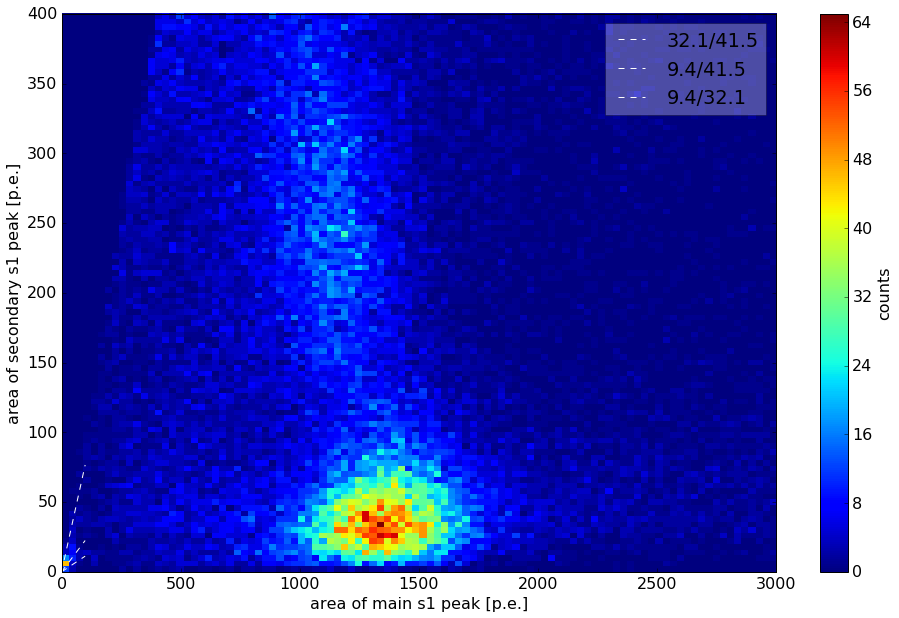

In [55]:
fig, ax1 = plt.subplots(1,1, figsize=(16,10))
plt.hist2d(main_areas, secondary_areas, bins=[100,100], range=((0,3000),(0,400)))
ax1.set_xlabel("area of main s1 peak [p.e.]")
ax1.set_ylabel("area of secondary s1 peak [p.e.]")
cbar = plt.colorbar()
cbar.set_label("counts")
#ax.set_xlim(0,150)
#ax.set_ylim(0,50)

#ax2.hist(peaks["index_of_maximum"], bins=512, histtype="step")
#ax2.set_yscale("log")
fig.show()
if save_plots:
    plot_save("secondaryArea_vs_mainArea",fig)
ax1.plot(np.arange(0,100), 32.1/41.5*np.arange(0,100), "w--", label="32.1/41.5")
ax1.plot(np.arange(0,100), 9.4/41.5*np.arange(0,100), "w--", label="9.4/41.5")
ax1.plot(np.arange(0,100), 9.4/(41.5+41.5)*np.arange(0,100), "w--", label="9.4/32.1")
leg = ax1.legend()
leg.get_frame().set_alpha(0.3)

In [13]:
time_differences = [p2["center_time"]-p1["center_time"] for p1, p2 in zip(main_peaks, secondary_peaks)]


[ 305.45104567  453.00318417]


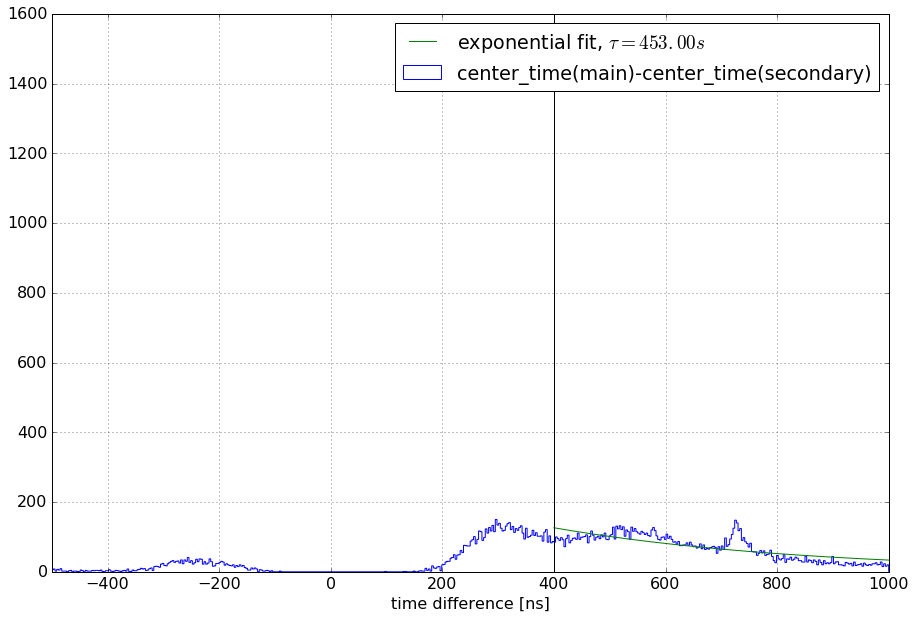

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
n, bins, patches = ax.hist(time_differences,bins=500, histtype="step", range=(-500,1000), label="center_time(main)-center_time(secondary)")
ax.set_xlim(-500, 1000)
ax.set_xlabel("time difference [ns]")
begin = 300
ax.vlines(bins[begin], 0, 1600 )
from scipy.optimize import curve_fit
def expfit(t, A, tau):
    return A*np.exp(-1/tau*t)
popt, cov = curve_fit(expfit, bins[begin:-1], n[begin:], p0=(600, 100))
print(popt)
ax.grid()

ax.plot(bins[begin:], expfit(bins[begin:], popt[0], popt[1]), label =r"exponential fit, $\tau = %.2f s$"%popt[-1])
ax.legend()
if save_plots:
    plot_save("timeDiff_vs_time",fig)

In [15]:
a = pd.DataFrame(hits)
a["right_left"] = a.right-a.left
a["height_over_noise"] = a.height / a.noise_sigma
b = pd.groupby(a, "channel")

0   121.459894476
1   127.528362593
2   107.718430161
3   107.26905761
4   108.082667538
5   87.4622858837
6   91.2312252816
7   105.62276303
8   91.1150650214
9   155.006021758
10   100.535933763
11   88.0471444218
12   146.973620303
13   121.637732112


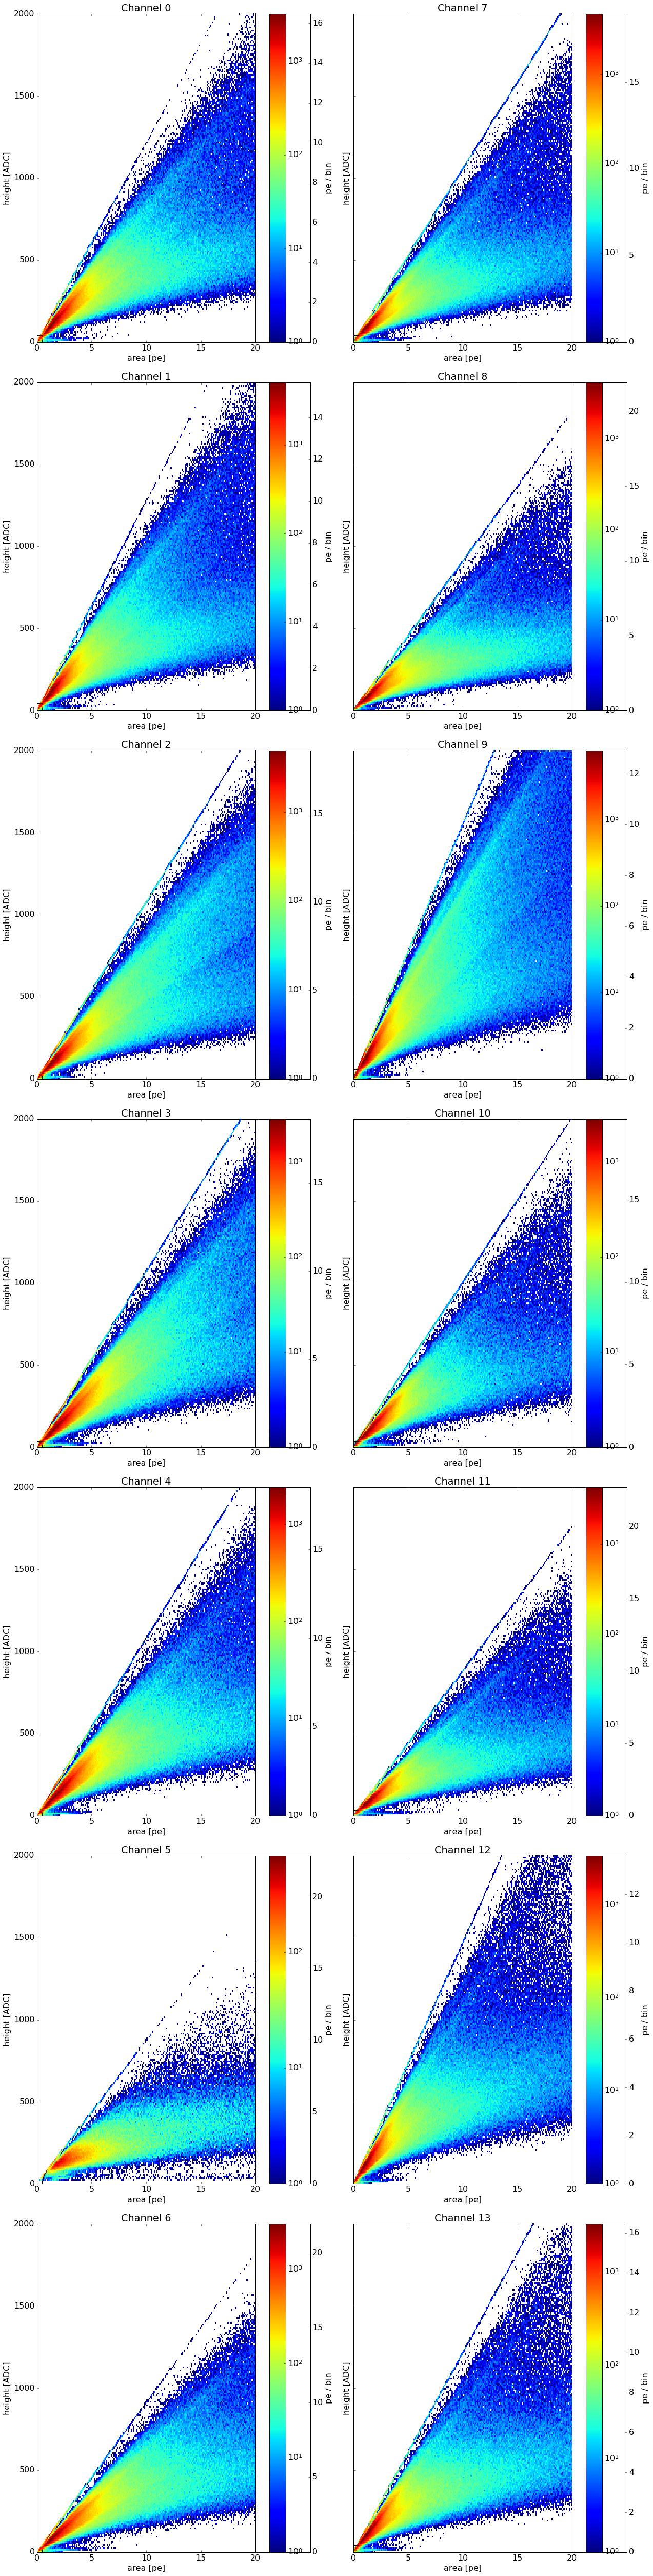

In [16]:
fit_results = pd.DataFrame()
fit_results["mu"]= [2082164.7936461328,
 2186195.434534125,
 1846597.3799506892,
 1838893.8683664894,
 1852841.4347904588,
 1499349.9971716139,
 1563960.2370998124,
 1810671.7409754544,
 1561968.9229686754,
 2657239.9284585249,
 1723469.1556580958,
 1509376.120301099,
 2519541.9369575349,
 2085213.4317763222]

zero_suppression_thresholds= [41.020546477981021,
 43.366217785112987,
 36.700572780737346,
 36.243802140278476,
 36.692074380224781,
 32.946717676219961,
 34.132194381369615,
 41.2305793813752,
 35.437312161345993,
 58.131877996628248,
 36.154995206872805,
 32.236508707900157,
 55.957430908535571,
 42.873913815503158]

fig, axes = plt.subplots(7, 2, figsize=(18,70), sharey= True)
#ax0, ax1 = axes
import pax.units as units
def pe_to_adc(gain):
    return units.electron_charge_SI * gain * 2**14*500/(2.25*1e-8)
for ch_i, channelhits in b:
        if ch_i<7:    # select the right axis
            ax = axes[ch_i][0]
        else:
            ax = axes[ch_i-7][1]
        #height_in_pe = np.apply_along_axis(pe_to_adc,0,fit_results["mu"])
        height_in_pe = channelhits["height"].values * pe_to_adc(fit_results["mu"][ch_i])
        print( ch_i," ", pe_to_adc(fit_results["mu"][ch_i]))
        n, xedges, yedges, Image = ax.hist2d(channelhits["area"].values, height_in_pe, range=((0,20), (0,2000)), bins=(200,200), label="Channel %d"%ch_i, norm=LogNorm())
        #ax0.plot(bins[:-1], n, "bo" )
        ax.vlines(0.5,0,zero_suppression_thresholds[ch_i],"k",linestyles="dashed")
        ax.hlines(zero_suppression_thresholds[ch_i], 0, 0.5)
        ax.set_title("Channel %d"%ch_i,)
        ax.set_ylabel("height [ADC]")
        #ax.set_xlim(0,5)
        #ax.set_ylim(0,200)
        ax2 = ax.twinx()
        mn, mx = ax.get_ylim()
        ax2.set_ylim(mn/pe_to_adc(fit_results["mu"][ch_i]), mx/pe_to_adc(fit_results["mu"][ch_i]))
        ax2.set_ylabel('pe / bin')
        ax.set_xlabel("area [pe]")
        #cbar = plt.colorbar()
        #cbar.set_label("counts")
        plt.colorbar(Image,ax=ax)
fig.tight_layout()
if save_plots:
    plot_save("height_vs_area_allChannels",fig)
#plt.colorbar()

/home/axel/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


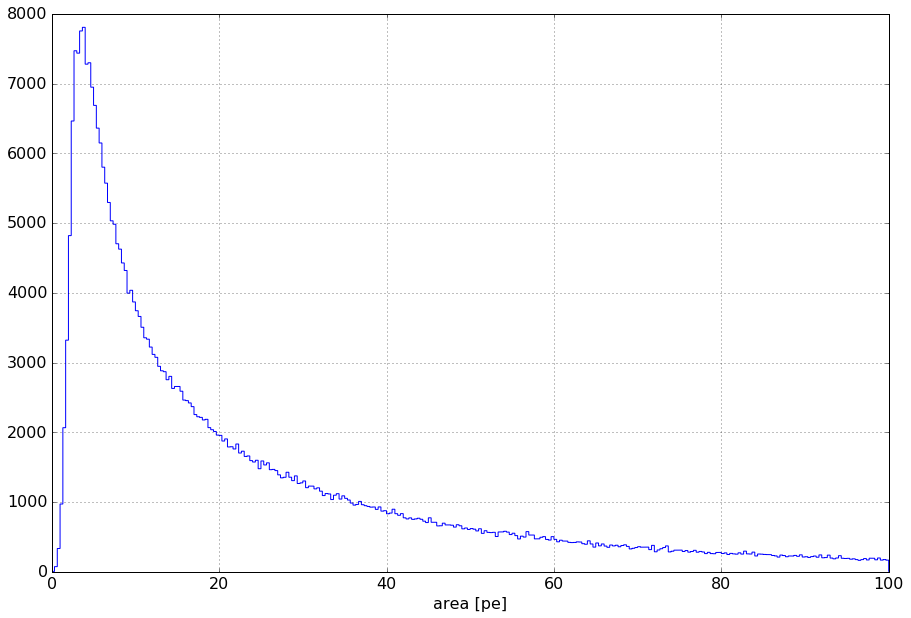

In [46]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
#n, bins, patches = ax.hist(main_areas,bins=500, histtype="step", range=(0,200), label="main peaks")
#n, bins, patches = ax.hist(secondary_areas,bins=500, histtype="step", range=(0,200), label="secondary peaks")
n, bins, patches = ax.hist(peaks[(peaks["n_contributing_channels"] >= 1) & (peaks["type"] == b"s1")]["area"],bins=300, histtype="step", range=(0,100), )
#ax.set_xlim(0, 5)
ax.grid(),
#ax.set_xticks(np.arange(0,200,10))
ax.legend()
ax.set_xlabel("area [pe]")
if save_plots:
    plot_save("timeDiff_vs_time",fig)
    
def gauss(x, *p):
    A, mu1, sigma1= p
    return A*np.exp(-(x-mu1)**2/(2.*sigma1**2))

def triple_gauss(x, *p):
    A1, mu1, sigma1 , A2, mu2, sigma2, A3, mu3, sigma3 = p
    #return A*np.exp(-(x-mu1)**2/(2.*sigma1**2))+A2*np.exp(-(x-2*mu2)**2/(2.*sigma2**2))+A3*np.exp(-(x-3*mu3)**2/(2.*sigma3**2))
    return gauss(x, A1, mu1, sigma1) + gauss(x, A2, mu2, sigma2) +gauss(x, A3, mu3, sigma3)
#     A     mu  sigma      
p0 = (100, 5,   1,
      1200,  35,  10,
      800, 70,  20)
from scipy import optimize
#ax.plot(bins, triple_gauss(bins, *p0), "k--") 

if False:
    popt, pcov, infodict, errmsg, success = optimize.curve_fit(triple_gauss, bins[:-1], n, p0, full_output=True)
    ax.plot(bins, triple_gauss(bins, *popt), "k-")
    ax.plot(bins, gauss(bins, *popt[:3]), "b--")
    ax.plot(bins, gauss(bins, *popt[3:6]), "b--")
    ax.plot(bins, gauss(bins, *popt[6:]), "b--")
#ax.set_yscale("log")
#ax.set_ylim(10, 6000)
    p_names =   ["A1", "mu1", "sigma1" , "A2", "mu2", "sigma2", "A3", "mu3", "sigma3"]
    for p_name, p in zip(p_names, popt):
        print(p_name,"\t", p)
    print("mu1/mu2 = %.3f"%(popt[1]/popt[4]))
    print("mu1/mu3 = %.3f"%(popt[1]/popt[7]))
    print("mu2/mu3 = %.3f"%(popt[4]/popt[7]))
    #ax.annotate(, )
    ax.annotate("mu1/mu2 = %.3f"%(popt[1]/popt[4]), (0.7, 0.8), xycoords="axes fraction" )
    ax.annotate("mu2/mu3 = %.3f"%(popt[4]/popt[7]), (0.7, 0.7), xycoords="axes fraction" )
    ax.annotate("mu1/mu3 = %.3f"%(popt[1]/popt[7]), (0.7, 0.6), xycoords="axes fraction" )
if save_plots :
    plot_save("hist_area_3or_more_channels_contributing",fig)

In [18]:
popt[1]/popt[7]

0.18406879446456009

In [19]:
popt[4]/popt[7]

0.4226299390451716

In [20]:
9.4/32.1

0.29283489096573206

In [21]:
9.4/41.5

0.22650602409638554

In [22]:
32.1/41.5

0.7734939759036145

In [49]:
events.dtype.names

('Event',
 'dataset_name',
 'event_number',
 'n_interactions',
 'interactions_start',
 'is_channel_suspicious',
 'lone_hits_per_channel',
 'lone_hits_per_channel_before',
 'n_channels',
 'n_hits_rejected',
 'noise_pulses_in',
 'n_peaks',
 'peaks_start',
 'sample_duration',
 'start_time',
 'stop_time')